# Sobol indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Gaussian Framework

In [2]:
from shapley.tests import AdditiveGaussian
dim = 3
beta = None
model = AdditiveGaussian(dim, beta)

### Monte-Carlo estimation using true model

In [3]:
%%time
from shapley import SobolIndices

ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 500

sobol = SobolIndices(model.input_distribution)

# Generate the samples
sobol.build_sample(model=model, n_sample=n_sample)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 7 ms


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 500
estimator = 'sobolmara'

# Indice estimation
sobol_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_results.true_first_indices = model.first_order_sobol_indices
sobol_results.true_total_indices = model.total_sobol_indices

CPU times: user 20 ms, sys: 16 ms, total: 36 ms
Wall time: 35.5 ms


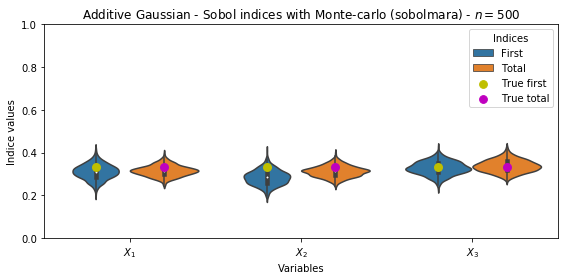

In [5]:
from shapley.plots import plot_sensitivity_results

ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_results, ax=ax)
ax.set_title("%s - Sobol indices with Monte-carlo (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [6]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 15
sampling = 'lhs'
library = 'sklearn'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling)
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [7]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000)
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.892385632927


In [8]:
%%time
n_realization = 500
sobol.build_sample(model=model_gp, n_sample=n_sample, n_realization=n_realization)

CPU times: user 43.3 s, sys: 1.2 s, total: 44.5 s
Wall time: 5.78 s


In [9]:
%%time
# Indice estimation
sobol_gp_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_gp_results.true_first_indices = model.first_order_sobol_indices
sobol_gp_results.true_total_indices = model.total_sobol_indices

CPU times: user 7.26 s, sys: 7.12 s, total: 14.4 s
Wall time: 13.4 s


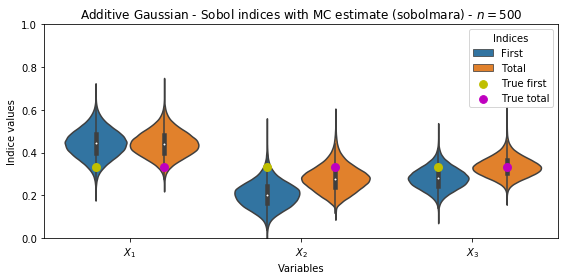

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_gp_results, ax=ax)
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

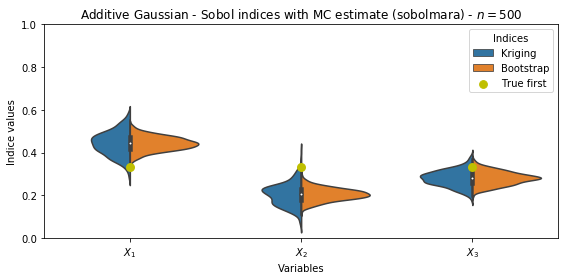

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_gp_results, ax=ax, indice='first')
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [12]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling)
model_rf.build(n_realization)

In [13]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000)
print('Q2-score by cross-validation:', q2_score_cv_rf)

Q2-score by cross-validation: 0.494442160462


In [14]:
%%time
sobol.build_sample(model_rf, n_sample=n_sample, n_realization=n_realization)

CPU times: user 292 ms, sys: 0 ns, total: 292 ms
Wall time: 290 ms


In [15]:
%%time
# Indice estimation
sobol_rf_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_rf_results.true_first_indices = model.first_order_sobol_indices
sobol_rf_results.true_total_indices = model.total_sobol_indices

CPU times: user 6.63 s, sys: 7.09 s, total: 13.7 s
Wall time: 13.8 s


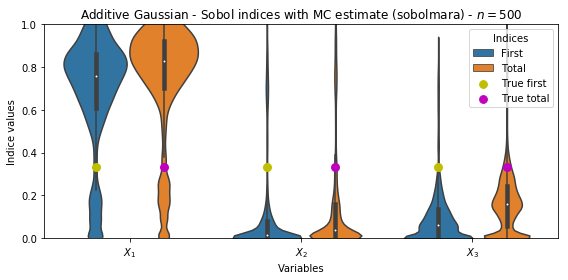

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_rf_results, ax=ax)
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

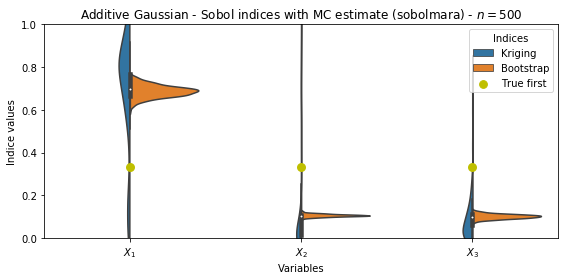

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_rf_results, ax=ax, indice='first')
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

In [19]:
X = model_rf.input_sample
y = model_rf.output_sample

In [22]:
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import autosklearn.regression

X = model_rf.input_sample
y = model_rf.output_sample
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

In [25]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120, per_run_time_limit=30)

In [ ]:
automl.fit(X_train, y_train)

print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

[WARNING] [2017-09-04 19:51:18,858:AutoMLSMBO(1)::2cace35283479d925423c15d27c95344] Could not find meta-data directory /home/D58174/anaconda2/envs/py35/lib/python3.5/site-packages/autosklearn/metalearning/files/r2_regression_dense


You are already timing task: index_run2
You are already timing task: index_run2
You are already timing task: index_run3
You are already timing task: index_run3
You are already timing task: index_run5
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6


[WARNING] [2017-09-04 19:52:27,979:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-09-04 19:52:27,979:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run6
You are already timing task: index_run7
You are already timing task: index_run7
You are already timing task: index_run7
You are already timing task: index_run7
You are already timing task: index_run7
